# SHAP Values Workshop

Welcome to the **SHAP Values Workshop**! During this session, we’ll explore how to interpret various machine learning model predictions using SHAP (SHapley Additive exPlanations).

## Workshop Overview

**Length**: 1.5 hours

**Introduction to SHAP Values (40 minutes)**
   - Overview of interpretability and its importance.
   - The theory behind Shapley values.
   - Intepreting SHAP plots.
   - Real world examples

**Break (10 minutes)**

**Hands-On SHAP Applications (40 minutes)**
   - Walkthrough with a simple multiple linear regression.
   - Walkthrough with a neural network (LSTM).
   - Walkthrough with a classifier.

**We’ll use pretrained models (trained on the CAMELS and GAGESII dataset). You’ll load each model, run the SHAP package to generate explanations, and discuss how to interpret them.**


#### **Objective**: For the first two parts of this workshop, we'll use two models (a multiple linear regression and LSTM model) trained on the CAMELS dataset to predict discharge from hydrometeorological and static catchment attribute data. We'll explore the feature importances and attributions in each of these models by utilizing SHAP values.

## 1. Data Preprocessing

### 1.1 Dataset Overview
- Let's do some preliminary exploratory data analysis on the CAMELS dataset



In [ ]:
import os
from pathlib import Path

# Set directories for accessing data, saved SHAP values, and pretrained models
DATA_DIR = os.path.join(Path.cwd(), 'Data')
OUTPUT_DIR = os.path.join(Path.cwd(), "outputs")
MODEL_DIR = os.path.join(Path.cwd(), "models")

In [2]:
# Read in data
import pandas as pd
df = pd.read_csv(Path(DATA_DIR, 'CAMELS_daymet_cleaned.csv'), index_col=0)
df.index = pd.to_datetime(df.index)

# Drop STAID from the dataframe
try:
    df.drop(columns=['STAID'], inplace=True)
except:
    print("STAID already dropped from dataframe")

- Print out the first 10 rows of the dataframe

In [3]:
df.head(10)

,Q,dayl(s),prcp(mm/day),srad(W/m2),tmax(C),tmin(C),vp(Pa),Annual Runoff (mm d-1),Annual Precip (mm d-1),Annual PET (mm d-1),Annual Temp (C),DA (km2),Elevation (m),Slope (m km-1),Frac Forest (%)
DATE,,,,,,,,,,,,,,,
1980-01-01,655.0,30172.51,0.00,153.40,-6.54,-16.30,171.69,1.66,2.781,1.95,3.931,2303.95,250.31,21.64152,0.9063
1980-01-02,640.0,30253.10,0.00,145.27,-6.18,-15.22,185.94,1.66,2.781,1.95,3.931,2303.95,250.31,21.64152,0.9063
1980-01-03,625.0,30344.18,0.00,146.96,-9.89,-18.86,138.39,1.66,2.781,1.95,3.931,2303.95,250.31,21.64152,0.9063
1980-01-04,620.0,30408.33,0.00,146.20,-10.98,-19.76,120.06,1.66,2.781,1.95,3.931,2303.95,250.31,21.64152,0.9063
1980-01-05,605.0,30413.48,0.00,170.43,-11.29,-22.21,117.87,1.66,2.781,1.95,3.931,2303.95,250.31,21.64152,0.9063
1980-01-06,585.0,30485.93,0.00,188.17,-11.80,-24.68,80.00,1.66,2.781,1.95,3.931,2303.95,250.31,21.64152,0.9063
1980-01-07,570.0,30598.72,6.69,170.30,-4.46,-23.73,80.00,1.66,2.781,1.95,3.931,2303.95,250.31,21.64152,0.9063
1980-01-08,555.0,30733.73,3.64,120.17,-2.78,-12.30,240.07,1.66,2.781,1.95,3.931,2303.95,250.31,21.64152,0.9063
1980-01-09,540.0,30758.40,0.00,170.71,-7.00,-17.41,159.10,1.66,2.781,1.95,3.931,2303.95,250.31,21.64152,0.9063


- Check to make sure there are no NAs present in our data

In [4]:
print(df.isna().sum())

Q                         0
dayl(s)                   0
prcp(mm/day)              0
srad(W/m2)                0
tmax(C)                   0
tmin(C)                   0
vp(Pa)                    0
Annual Runoff (mm d-1)    0
Annual Precip (mm d-1)    0
Annual PET (mm d-1)       0
Annual Temp (C)           0
DA (km2)                  0
Elevation (m)             0
Slope (m km-1)            0
Frac Forest (%)           0
dtype: int64


- Look at summary statistics of the data

In [5]:
df.describe()

,Q,dayl(s),prcp(mm/day),srad(W/m2),tmax(C),tmin(C),vp(Pa),Annual Runoff (mm d-1),Annual Precip (mm d-1),Annual PET (mm d-1),Annual Temp (C),DA (km2),Elevation (m),Slope (m km-1),Frac Forest (%)
count,8.093721e+06,8.093721e+06,8.093721e+06,8.093721e+06,8.093721e+06,8.093721e+06,8.093721e+06,8.093721e+06,8.093721e+06,8.093721e+06,8.093721e+06,8.093721e+06,8.093721e+06,8.093721e+06,8.093721e+06
mean,2.739956e+02,4.320308e+04,3.278911e+00,3.389220e+02,1.685438e+01,4.471958e+00,9.675320e+02,1.499484e+00,3.066438e+00,2.936086e+00,1.107716e+01,6.534954e+02,7.066424e+02,4.502335e+01,6.455463e-01
std,8.735541e+02,7.130531e+03,7.830815e+00,1.297875e+02,1.108922e+01,1.008839e+01,6.572697e+02,1.551354e+00,1.364052e+00,6.203871e-01,5.262925e+00,8.646884e+02,7.109040e+02,4.636179e+01,3.721971e-01
min,0.000000e+00,2.901251e+04,0.000000e+00,1.305000e+01,-3.807000e+01,-4.884000e+01,0.000000e+00,8.000000e-03,4.730000e-01,1.891000e+00,-5.729000e+00,6.100000e+00,1.021000e+01,8.222100e-01,0.000000e+00
25%,8.200000e+00,3.663362e+04,0.000000e+00,2.416700e+02,8.520000e+00,-2.230000e+00,4.771700e+02,6.570000e-01,2.268000e+00,2.433000e+00,7.179000e+00,1.345600e+02,2.415300e+02,7.250430e+00,2.772000e-01
50%,4.700000e+01,4.320000e+04,0.000000e+00,3.415300e+02,1.801000e+01,4.440000e+00,7.600000e+02,1.105000e+00,2.994000e+00,2.824000e+00,1.059300e+01,3.434600e+02,4.485300e+02,2.707084e+01,8.219000e-01
75%,1.930000e+02,4.976638e+04,2.840000e+00,4.372300e+02,2.579000e+01,1.202000e+01,1.332340e+03,1.722000e+00,3.487000e+00,3.308000e+00,1.438100e+01,7.931500e+02,8.756700e+02,7.081645e+01,9.741000e-01
max,4.990000e+04,5.738758e+04,2.000000e+02,8.000000e+02,4.550000e+01,2.850000e+01,3.659250e+03,9.734000e+00,1.090400e+01,5.261000e+00,2.386400e+01,5.915630e+03,3.116820e+03,2.556884e+02,1.000000e+00


- Look at distributions of data

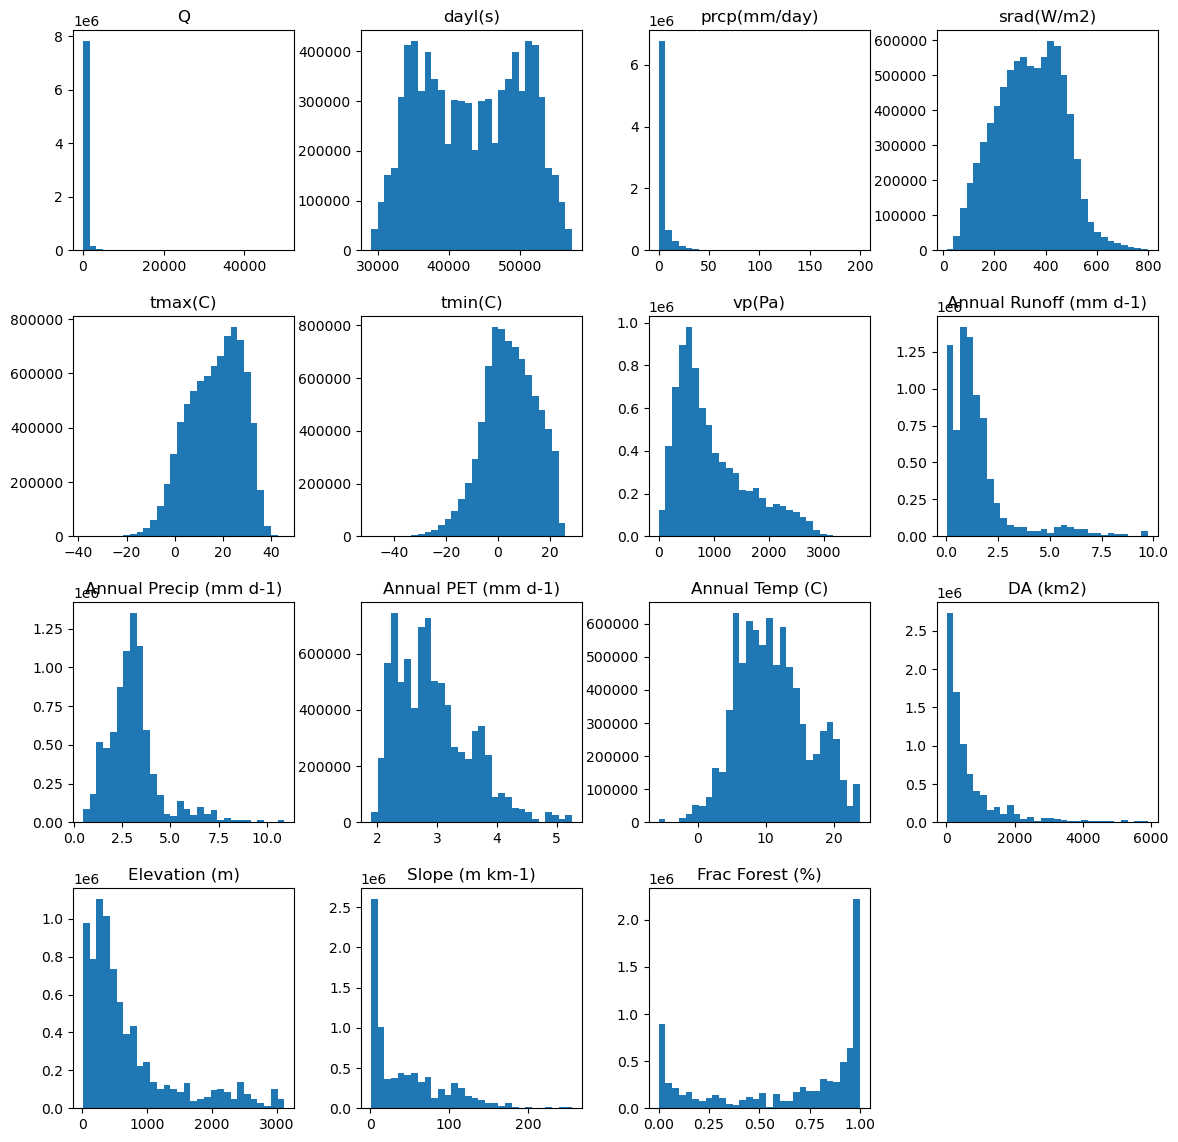

In [6]:
import matplotlib.pyplot as plt
df.hist(bins=30, figsize=(14, 14), grid=False)
plt.show()

### 1.2.1 Preprocess data for the Multiple Linear Regression Model
- Split dataframe in X (inputs) and y (target), scale input data, and split into training and testing sets

In [7]:
from sklearn.preprocessing import StandardScaler
X = df.drop('Q', axis=1)
y = df['Q']

feat_scaler = StandardScaler()
X_sc = pd.DataFrame(
    feat_scaler.fit_transform(X),
    columns=X.columns,
    index=X.index
)

y_scaler = StandardScaler()
y_sc = pd.Series(y_scaler.fit_transform(y.values.reshape(-1,1)).squeeze(),
    index=y.index, name='Q')

# get mean and scaler value for y_scaler, which we'll use to retranform the SHAP values later
y_scaler_mean = y_scaler.mean_[0]
y_scaler_scale = y_scaler.scale_[0]

# Split the data into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sc, y_sc, test_size=0.2, random_state=42)

### 1.2.2 Process data for the LSTM model

- Reshape data for LSTM (n_batches, window_length, n_features)

In [8]:
from src.model_building import build_lstm_windows
window_length = 60 # days
X_rs, y_rs = build_lstm_windows(X_test, y_test, window_length)
print(X_rs.shape)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


(1618686, 60, 14)


## 2. Applying SHAP to a Multiple Linear Regression

### 2.1 Loading the Pretrained Multiple Linear Regression
Use `np.load()` to load a pretrained multiple linear regression model

In [9]:
# Load in pre-trained multiple linear regression model
import numpy as np
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.coef_ = np.load(Path(MODEL_DIR, 'linreg_model.npz'))['coefficients']
linreg.intercept_ = np.load(Path(MODEL_DIR, 'linreg_model.npz'))['intercept']

### 2.2 Running SHAP Explanations
We'll use SHAP's `Explainer` for the **Multiple Linear Regression model**. Then we generate `shap_values` for the dataset.


In [10]:
import shap
# Get 10,000 random samples from the dataset
np.random.seed(42)
idx = np.random.choice(len(X_sc), size=10000, replace=False)
X_shap = X_sc.iloc[idx]        
y_shap = y_sc.iloc[idx]
feature_names = list(X.columns)

# Generate shap Explainer object and shap values
linear_explainer = shap.Explainer(linreg, X_shap)
shap_values = linear_explainer(X_shap)

- Let's take a look at our raw SHAP values

In [11]:
print(shap_values)

.values =
array([[ 3.97603006e-02,  3.21729778e-01, -2.46803044e-02, ...,
         9.74351501e-04,  6.34061035e-02,  1.61596014e-02],
       [-2.89863663e-02, -2.92188963e-02,  2.09136000e-02, ...,
         5.03934108e-03, -3.95292411e-02, -1.69236959e-04],
       [-2.27366282e-02, -2.92188963e-02,  8.39507876e-03, ...,
         5.52924691e-03, -4.12619025e-02, -2.91586258e-02],
       ...,
       [ 3.03857613e-02, -2.92188963e-02, -7.69138168e-03, ...,
         6.19498394e-03, -3.93897325e-02,  9.43771168e-03],
       [ 2.88233381e-02, -2.92188963e-02, -3.00025409e-03, ...,
         6.80208046e-03, -4.06562256e-02,  1.46873291e-02],
       [ 1.63239071e-02, -2.92188963e-02, -2.88676178e-04, ...,
         2.96812909e-03, -8.95192847e-03,  1.39239287e-02]])

.base_values =
array([-0.03026, -0.03026, -0.03026, ..., -0.03026, -0.03026, -0.03026])

.data =
array([[-1.35752566,  4.25895544, -1.44229601, ...,  0.0297615 ,
         1.66435139,  0.95232783],
       [ 0.77505195, -0.41871907,  

The SHAP values are in units of the scaled inputs/output, so we need to rescale the SHAP values so we can interpret them in their original units.

In [12]:
# Multiply by the scaler values
shap_values.values *= y_scaler_scale
shap_values.base_values *= y_scaler_scale

# Add the mean to the base values (model mean) to rescale
shap_values.base_values += y_scaler_mean

# Rescale the input data
shap_values.data = feat_scaler.inverse_transform(shap_values.data)
X_shap_untransformed = feat_scaler.inverse_transform(X_shap)

In [13]:
print(shap_values)

.values =
array([[ 3.47327714e+01,  2.81048349e+02, -2.15595797e+01, ...,
         8.51148694e-01,  5.53886581e+01,  1.41162852e+01],
       [-2.53211575e+01, -2.55242851e+01,  1.82691598e+01, ...,
         4.40213678e+00, -3.45309284e+01, -1.47837630e-01],
       [-1.98616735e+01, -2.55242851e+01,  7.33355500e+00, ...,
         4.83009600e+00, -3.60445018e+01, -2.54716355e+01],
       ...,
       [ 2.65436047e+01, -2.55242851e+01, -6.71883757e+00, ...,
         5.41165328e+00, -3.44090601e+01,  8.24435120e+00],
       [ 2.51787436e+01, -2.55242851e+01, -2.62088410e+00, ...,
         5.94198489e+00, -3.55154102e+01,  1.28301757e+01],
       [ 1.42598151e+01, -2.55242851e+01, -2.52174242e-01, ...,
         2.59282117e+00, -7.81999332e+00,  1.21633042e+01]])

.base_values =
array([247.56180914, 247.56180914, 247.56180914, ..., 247.56180914,
       247.56180914, 247.56180914])

.data =
array([[3.3523200e+04, 3.6630000e+01, 1.5173000e+02, ..., 7.2780000e+02,
        1.2218566e+02, 1.000000

**Now the SHAP values are in their respective original units.**

### 2.3 Visualizing SHAP values
- The SHAP package has built in visualizations to help interpret SHAP values. We can examine SHAP values globally or for local predictions.
- In this workshop, we'll explore 5 visualization techniques:

    1. **Bar Plot** (Feature importances)
    
    2. **Beeswarm plot** (feature importances and attribution)

    3. **Dependence plot** (How a single feature affects predictions)

    4. **Force Plot** (balance of forces for a given prediction)

    5. **Waterfall Plot** (a waterfall plot is similar to a force plot, but it steps through each feature contribution sequentially)


#### 2.3.1 Bar Plots
- Compares features by the height of their bars, each bar representing that feature’s average absolute SHAP value.

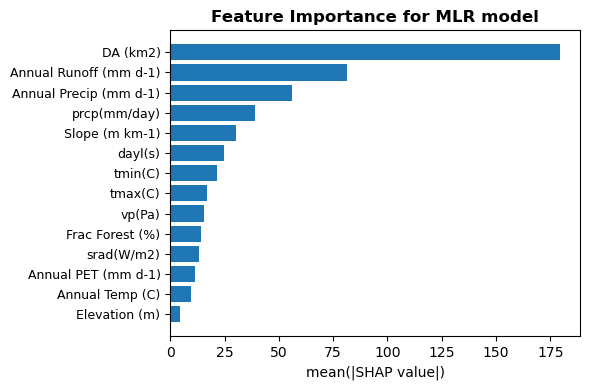

In [14]:
from src.visualization import plot_shap_bar_unscaled

plot_shap_bar_unscaled(
        shap_values,
        feature_names=X.columns,
        title="Feature Importance for MLR model"
)
plt.show()

- We can check to make sure this generally aligns with the coefficients of our MLR model

In [15]:
coefs = {}
for i, col in enumerate(list(X_sc.columns)):
    coefs[col] = linreg.coef_[i]
coefs = sorted(coefs.items(), key=lambda x: np.abs(x[1]), reverse=True)
for var, coef in coefs:
    print(f"MLR coefficient for {var}: {round(coef, 3)}")

MLR coefficient for DA (km2): 0.312
MLR coefficient for Annual Runoff (mm d-1): 0.157
MLR coefficient for Annual Precip (mm d-1): 0.095
MLR coefficient for prcp(mm/day): 0.075
MLR coefficient for Slope (m km-1): 0.041
MLR coefficient for dayl(s): -0.032
MLR coefficient for tmin(C): 0.03
MLR coefficient for tmax(C): -0.023
MLR coefficient for vp(Pa): -0.022
MLR coefficient for Frac Forest (%): 0.018
MLR coefficient for srad(W/m2): 0.018
MLR coefficient for Annual PET (mm d-1): -0.016
MLR coefficient for Annual Temp (C): 0.014
MLR coefficient for Elevation (m): -0.006


The MLR coefficients generally line up with the feature importances we see from SHAP. We can expect some variability because the SHAP values are calculated over a random subset of the data.

#### 2.3.2 Beeswarm plots
- Packs every SHAP value (from set of data used to generate them) into one figure: each dot shows a single observation, its position shows impact on model predictions (left = negative, right = positive), and its color encodes the raw feature value. 

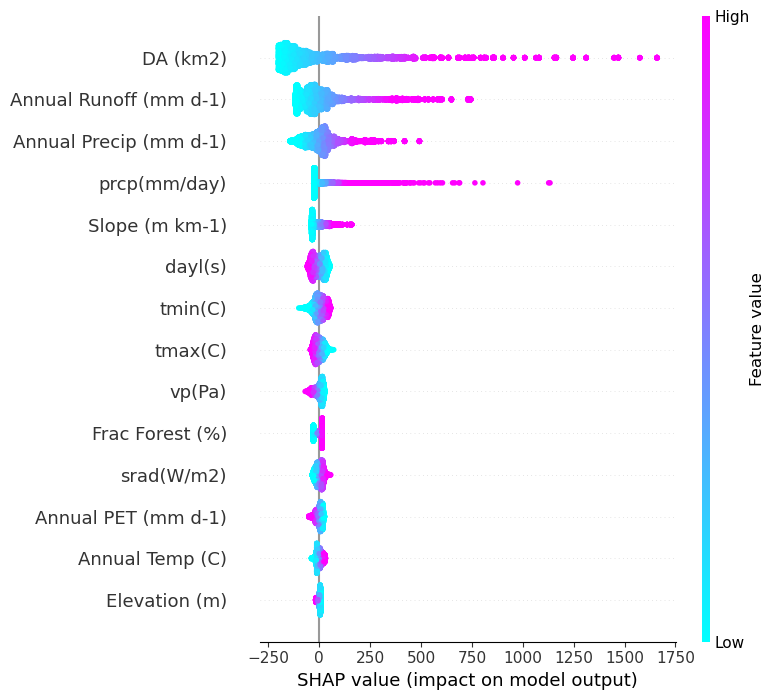

In [16]:
# A feature attribution (beeswarm) plot
shap.summary_plot(shap_values, X_shap_untransformed, feature_names=feature_names, cmap='cool')

#### 2.3.3 Dependence plots
- A scatter plot of a feature’s raw value (x-axis) versus its SHAP value (y-axis). It traces how changing that feature pushes the prediction up or down across the dataset.

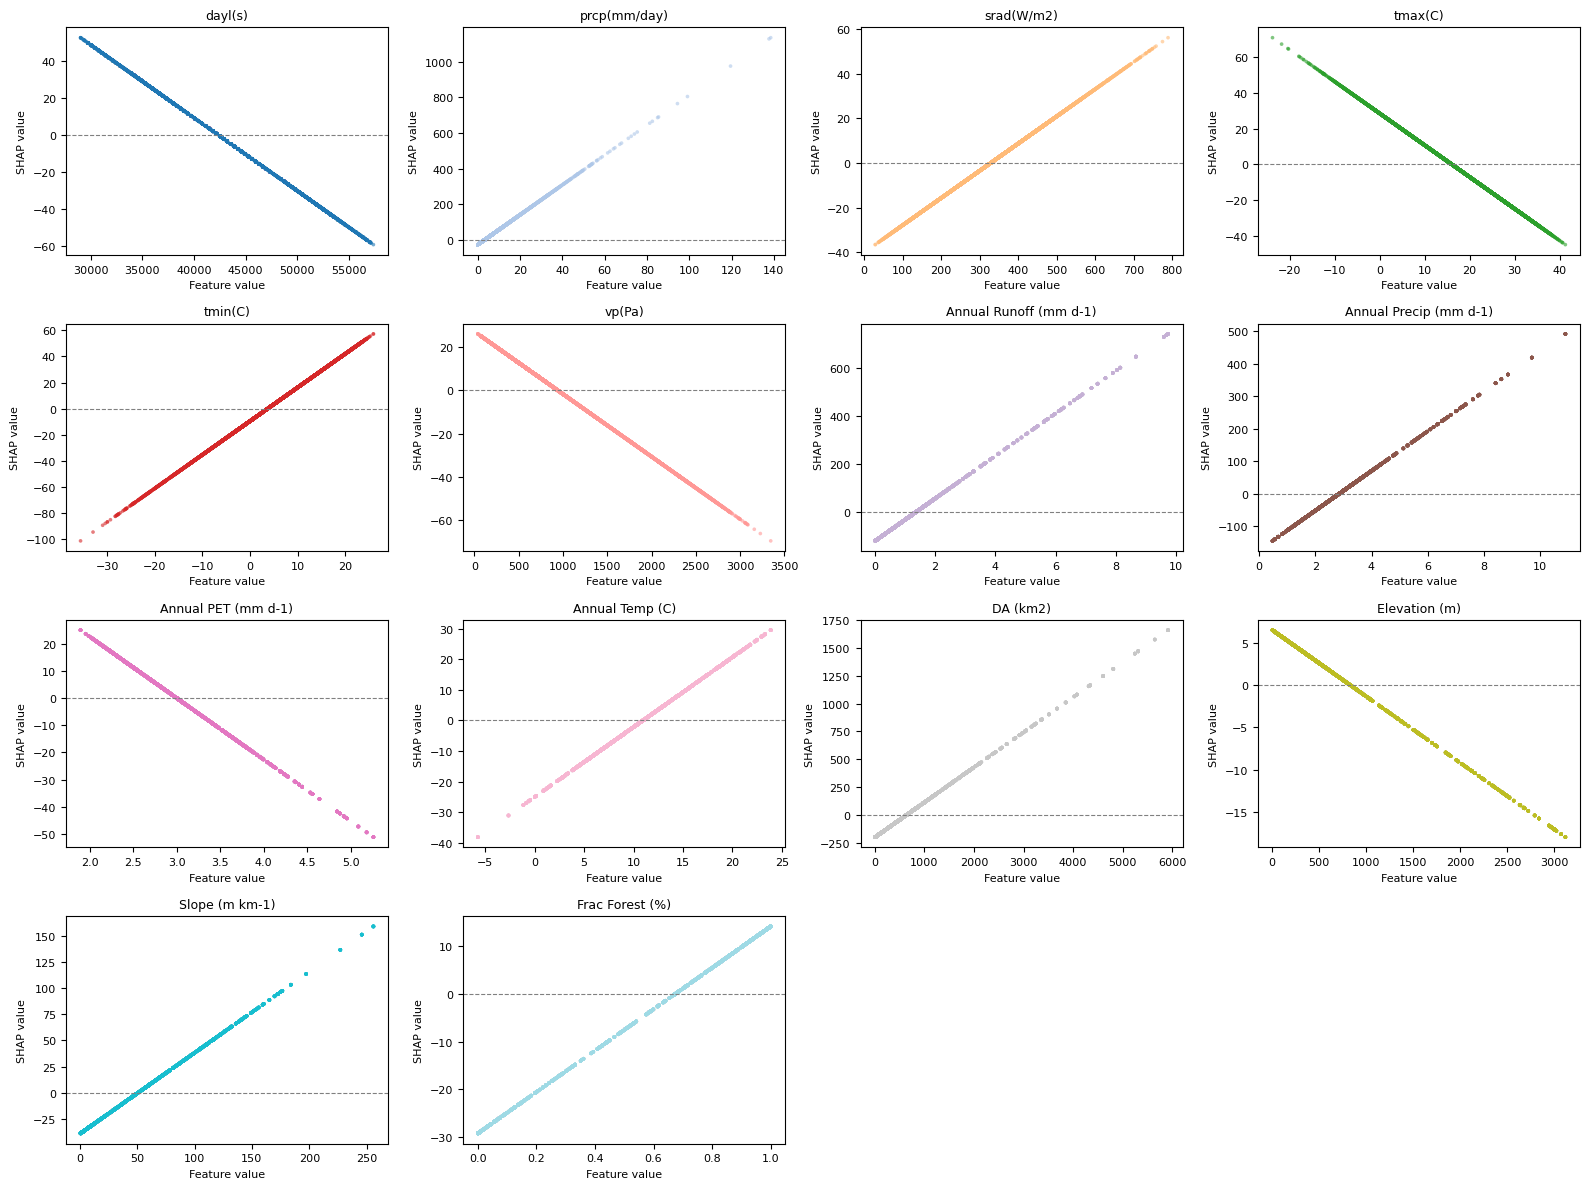

<Figure size 640x480 with 0 Axes>

In [17]:
from src.visualization import plot_all_dependence

fig, axes = plot_all_dependence(
                shap_values       = shap_values,       
                X_values          = X_shap_untransformed,
                feature_names     = feature_names,
                n_cols            = 4,
                point_size        = 7,
                alpha             = 0.6,
                cmap_name         = "tab20")
plt.show()

plt.tight_layout()
plt.show()

#### 2.3.4 Force Plots
- Breaks one individual prediction into colored blocks along a line: blocks to the right push the prediction higher, blocks to the left push it lower.

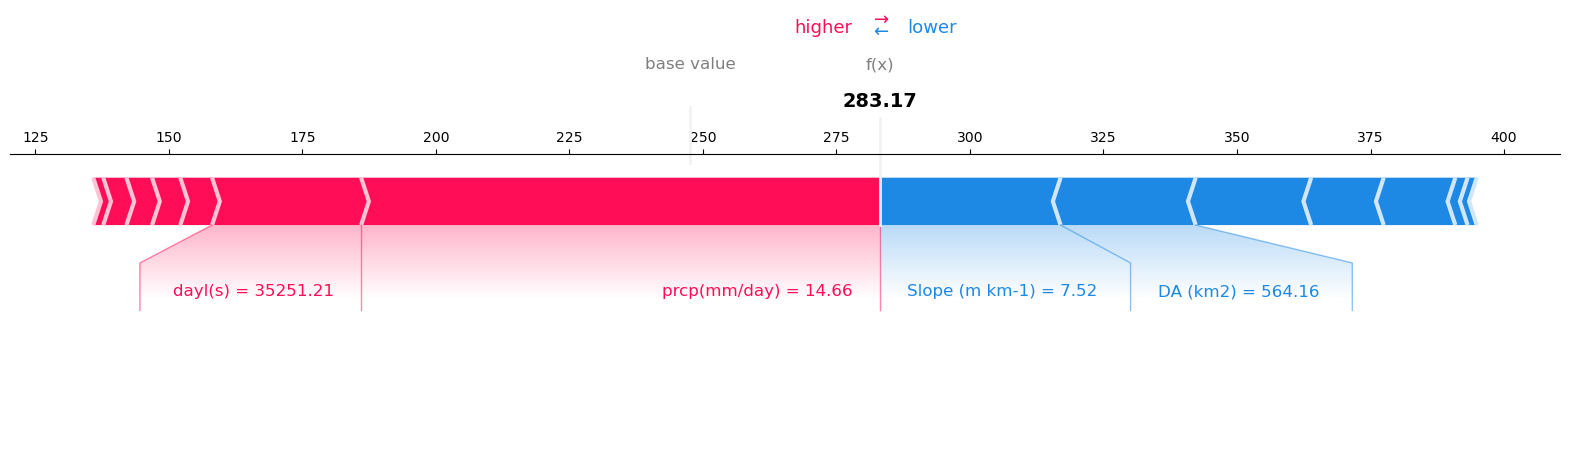

<Figure size 640x480 with 0 Axes>

In [18]:
# Get a random index to show a force plot interpretation
np.random.seed(42)
row = np.random.randint(0, len(X_shap))

# Round features for display
feat_raw = X_shap_untransformed[row, :]
feat_round = feat_raw.round(2)

# Plot force plot
shap.initjs()               
shap.force_plot(
        base_value = shap_values.base_values[row],
        shap_values = shap_values.values[row],
        features    = feat_round,
        feature_names = feature_names,
        figsize=(20, 4),
        matplotlib = True              
)
plt.tight_layout()
plt.show()

#### 2.3.5 Waterfall plots
- Starts at the model’s expected value and adds (or subtracts) feature contributions step-by-step, largest to smallest. The cumulative “waterfall” shows exactly how the prediction is reached feature by feature.

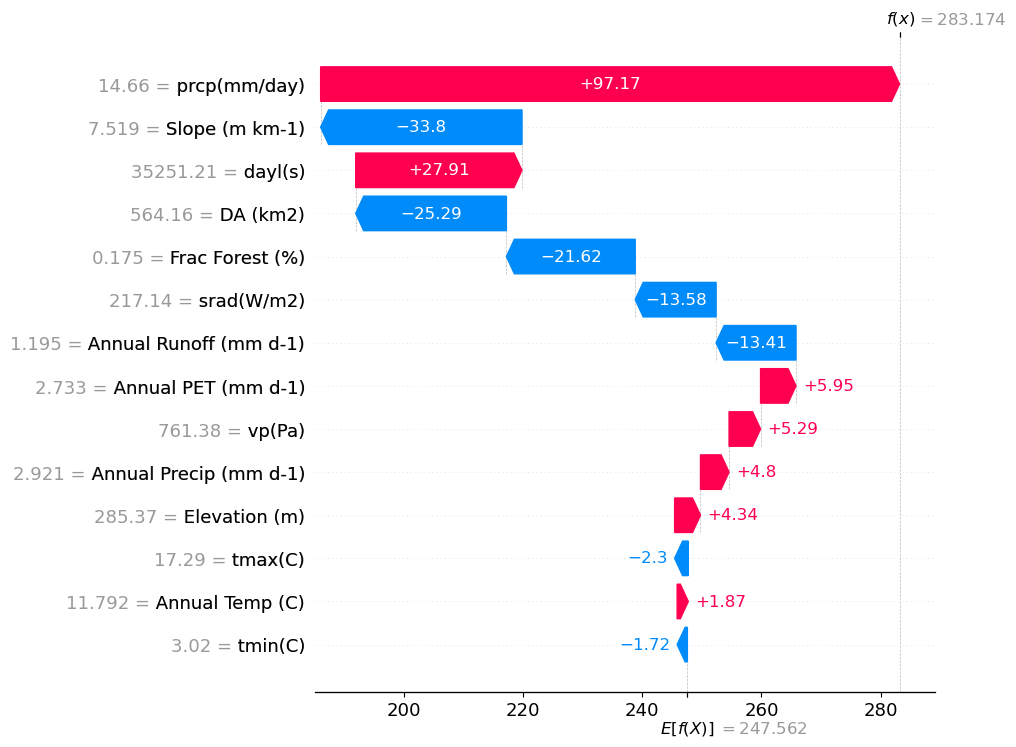

In [19]:
shap.plots.waterfall(shap_values[row], max_display=15)

## 3. Neural Network (LSTM) with SHAP

- Now we'll demonstrate generating and interpreting SHAP values with a Neural Network (LSTM) model

### 3.1 Build LSTM model, load pretrained weights, and get SHAP values
- Generating SHAP values with an LSTM takes longer than with a simpler model, so we'll load them in from a file. If you're curious how to implement this from scratch, check out the `get_lstm_shap_vals()` and `load_npz_array()` functions from the `/src` folder.

In [20]:
from src.model_building import get_lstm_shap_vals, load_npz_array

WEIGHTS_PATH = MODEL_DIR + "/LSTM_weights_daymet.weights.h5"
SHAP_PATH = OUTPUT_DIR + "/shap_daymet.npz"
BASEVALS_PATH = OUTPUT_DIR + "/basevals_daymet.npz"
SHAP_DATA_PATH = OUTPUT_DIR + "/shap_data_daymet.npz"

try:
    shap_values_2d = load_npz_array(SHAP_PATH, key="shap_values_2d")
    base_values_2d = load_npz_array(BASEVALS_PATH, key="base_values_2d")
    data_2d = load_npz_array(SHAP_DATA_PATH, key="data_2d")
except:
    shap_values_2d, shap_base_values_2d, data_2d = get_lstm_shap_vals(weights_path=WEIGHTS_PATH, hidden_units=8, window_length=60, n_cols=X_train.shape[1], 
                                                                      n_batches=1000, X_rs=X_rs, feat_scaler=feat_scaler, y_scaler=y_scaler, shap_outpath=SHAP_PATH,
                                                                      basevals_outpath=BASEVALS_PATH, shap_data_outpath=SHAP_DATA_PATH)

### 3.2 Visualize LSTM SHAP values

#### 3.2.1 Beeswarm plot

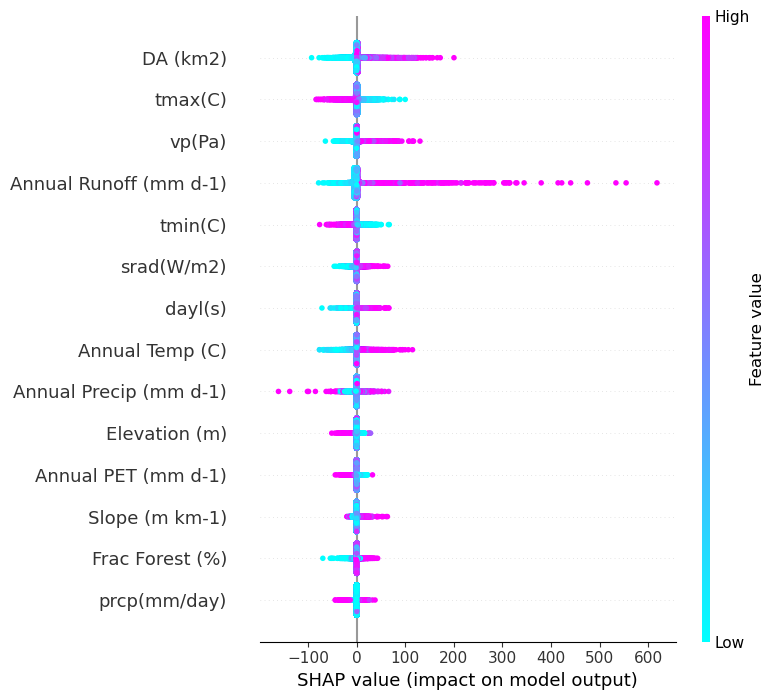

In [21]:
shap.summary_plot(shap_values_2d, data_2d, feature_names=feature_names, cmap='cool')

How do these feature importances and attributions align with our expectations, how do they differ? 

If they do deviate from our expectations, what could be causing the unexpected behavior?

#### 3.2.2 Dependence plots

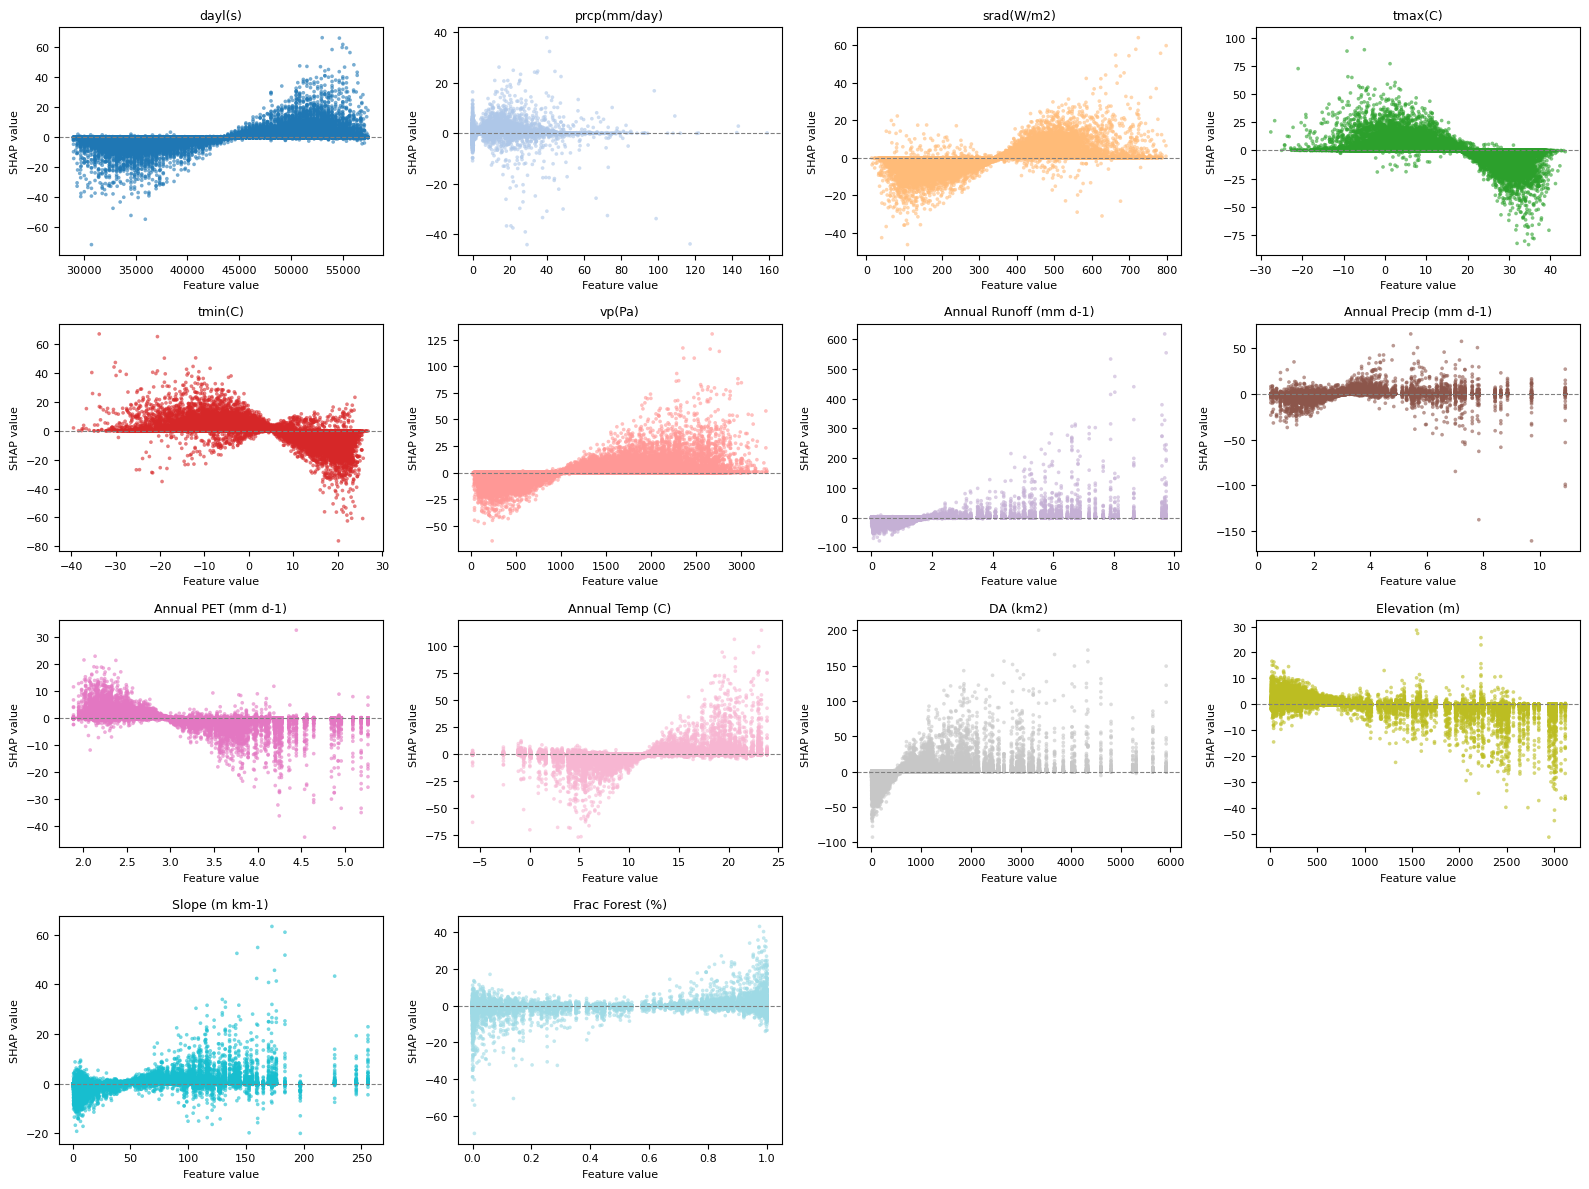

<Figure size 640x480 with 0 Axes>

In [22]:
fig, axes = plot_all_dependence(
                shap_values       = shap_values_2d,       
                X_values          = data_2d,
                feature_names     = feature_names,
                n_cols            = 4,
                point_size        = 7,
                alpha             = 0.6,
                cmap_name         = "tab20")
plt.show()

plt.tight_layout()
plt.show()

How is the dependence plot from the LSTM different from the MLR dependence plot?

What does this tell you about the behavior of these models?

## 4. Applying SHAP to a Classifier
Objective:  Use SHAP values to explore features associated with unique baseflow regimes.

### 4.1 Dataset Overview
- Approximately 800 reference-quality gages across CONUS from GAGES-II dataset.
- Watershed characteristics (climatic, geographic, hydrologic, geologic, land use, etc....) for each gage.
- Gages clustered into seven clusters based on long-term baseflow behavior.

### 4.2 Methodology
- Random Forest Classification model used to predict a gage's cluster based on watershed characteristics.
- SHAP explanation object generated on the classification model.

See:    *van der Heijden, R., Dadkhah, A., Hamshaw, S., Ghazanfari, E., Dewoolkar, M., Jones, N., Williams, G., Prabhakar, C., Rizzo, D.M.
        "Identifying and interpreting physical processes and NWM prediction bias associated with baseflow regimes across the CONUS".
        Water Resources Research (under review)*


Questions / comments: rvanderh@uvm.edu


In [23]:
#%% Import Libraries
import numpy as np
import pandas as pd
import shap
import os
import matplotlib.pyplot as plt
from matplotlib import colors
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split

# set up plot preferences
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['font.size'] = 12

In [24]:
data = pd.read_csv(os.path.join(DATA_DIR, 'RF_classifier_DevCon.csv'))
data.drop(columns=['STAID'], inplace=True)

In [25]:
# Model Setup
y = data['Cluster_H_7']
X = data.drop(columns=['Cluster_H_7'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# The model parameters have already been tuned
tuned_params = {
    'n_estimators': 800,
    'max_features': 'sqrt',
    'max_depth': 70,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'bootstrap': True
    }

In [26]:
# Fit model to training data
rf = RandomForestClassifier(n_estimators = tuned_params['n_estimators'],
                            max_depth = tuned_params['max_depth'],
                            max_features = tuned_params['max_features'],
                            min_samples_leaf = tuned_params['min_samples_leaf'],
                            min_samples_split = tuned_params['min_samples_split'],
                            bootstrap = tuned_params['bootstrap'],
                            random_state = 742
                            )

rf.fit(X_train, y_train)

# Add cluster number to X_test
X_test = pd.merge(left=X_test, right=data['Cluster_H_7'], left_index=True, right_index=True)

In [27]:
# Get feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

### 4.3 About the Explanation Object
- The explanation object was created only using the test subset of the data
- For this exercise, the explanation object only included the 10 most important features.
- The size of the explanation object depends on these factors:


[# data points : # features : # output classes]

[156 data points in the test set : 10 features : 7 output classes]

In [28]:
# Generate explanation object and compute SHAP values
explainer = shap.Explainer(rf, X_test)
sv = explainer(X_test, check_additivity=False)

# check the shape of the explanation object
sv.shape

100%|===================| 1090/1092 [01:41<00:00]        

(156, 11, 7)

### 3.4 About the Beeswarm Plot

The beeswarm plot is a collection of features associated with the output class. For a classification model, each output class has it's own beeswarm plot.

The features are arranged on the y-axis and ordered by feature importance, with the most importand features appearing at the top.

For each feature, all data points are shown (i.e., in this case 156 data points), arranged along the x-axis by their **SHAP value**, with vertical spread indicating density akin to a violin plot.

The data points are color-coded based on their **feature value**. Note that the color ramp is scaled to the range of values of each feature individually, thus is shows a relative magnitude ("high" or "low" feature values).

To interrogate the model further, we can look at the actual distribution of feature values (more on this later...).

[Text(0, 0, 'Low'), Text(1, 0, 'High')]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


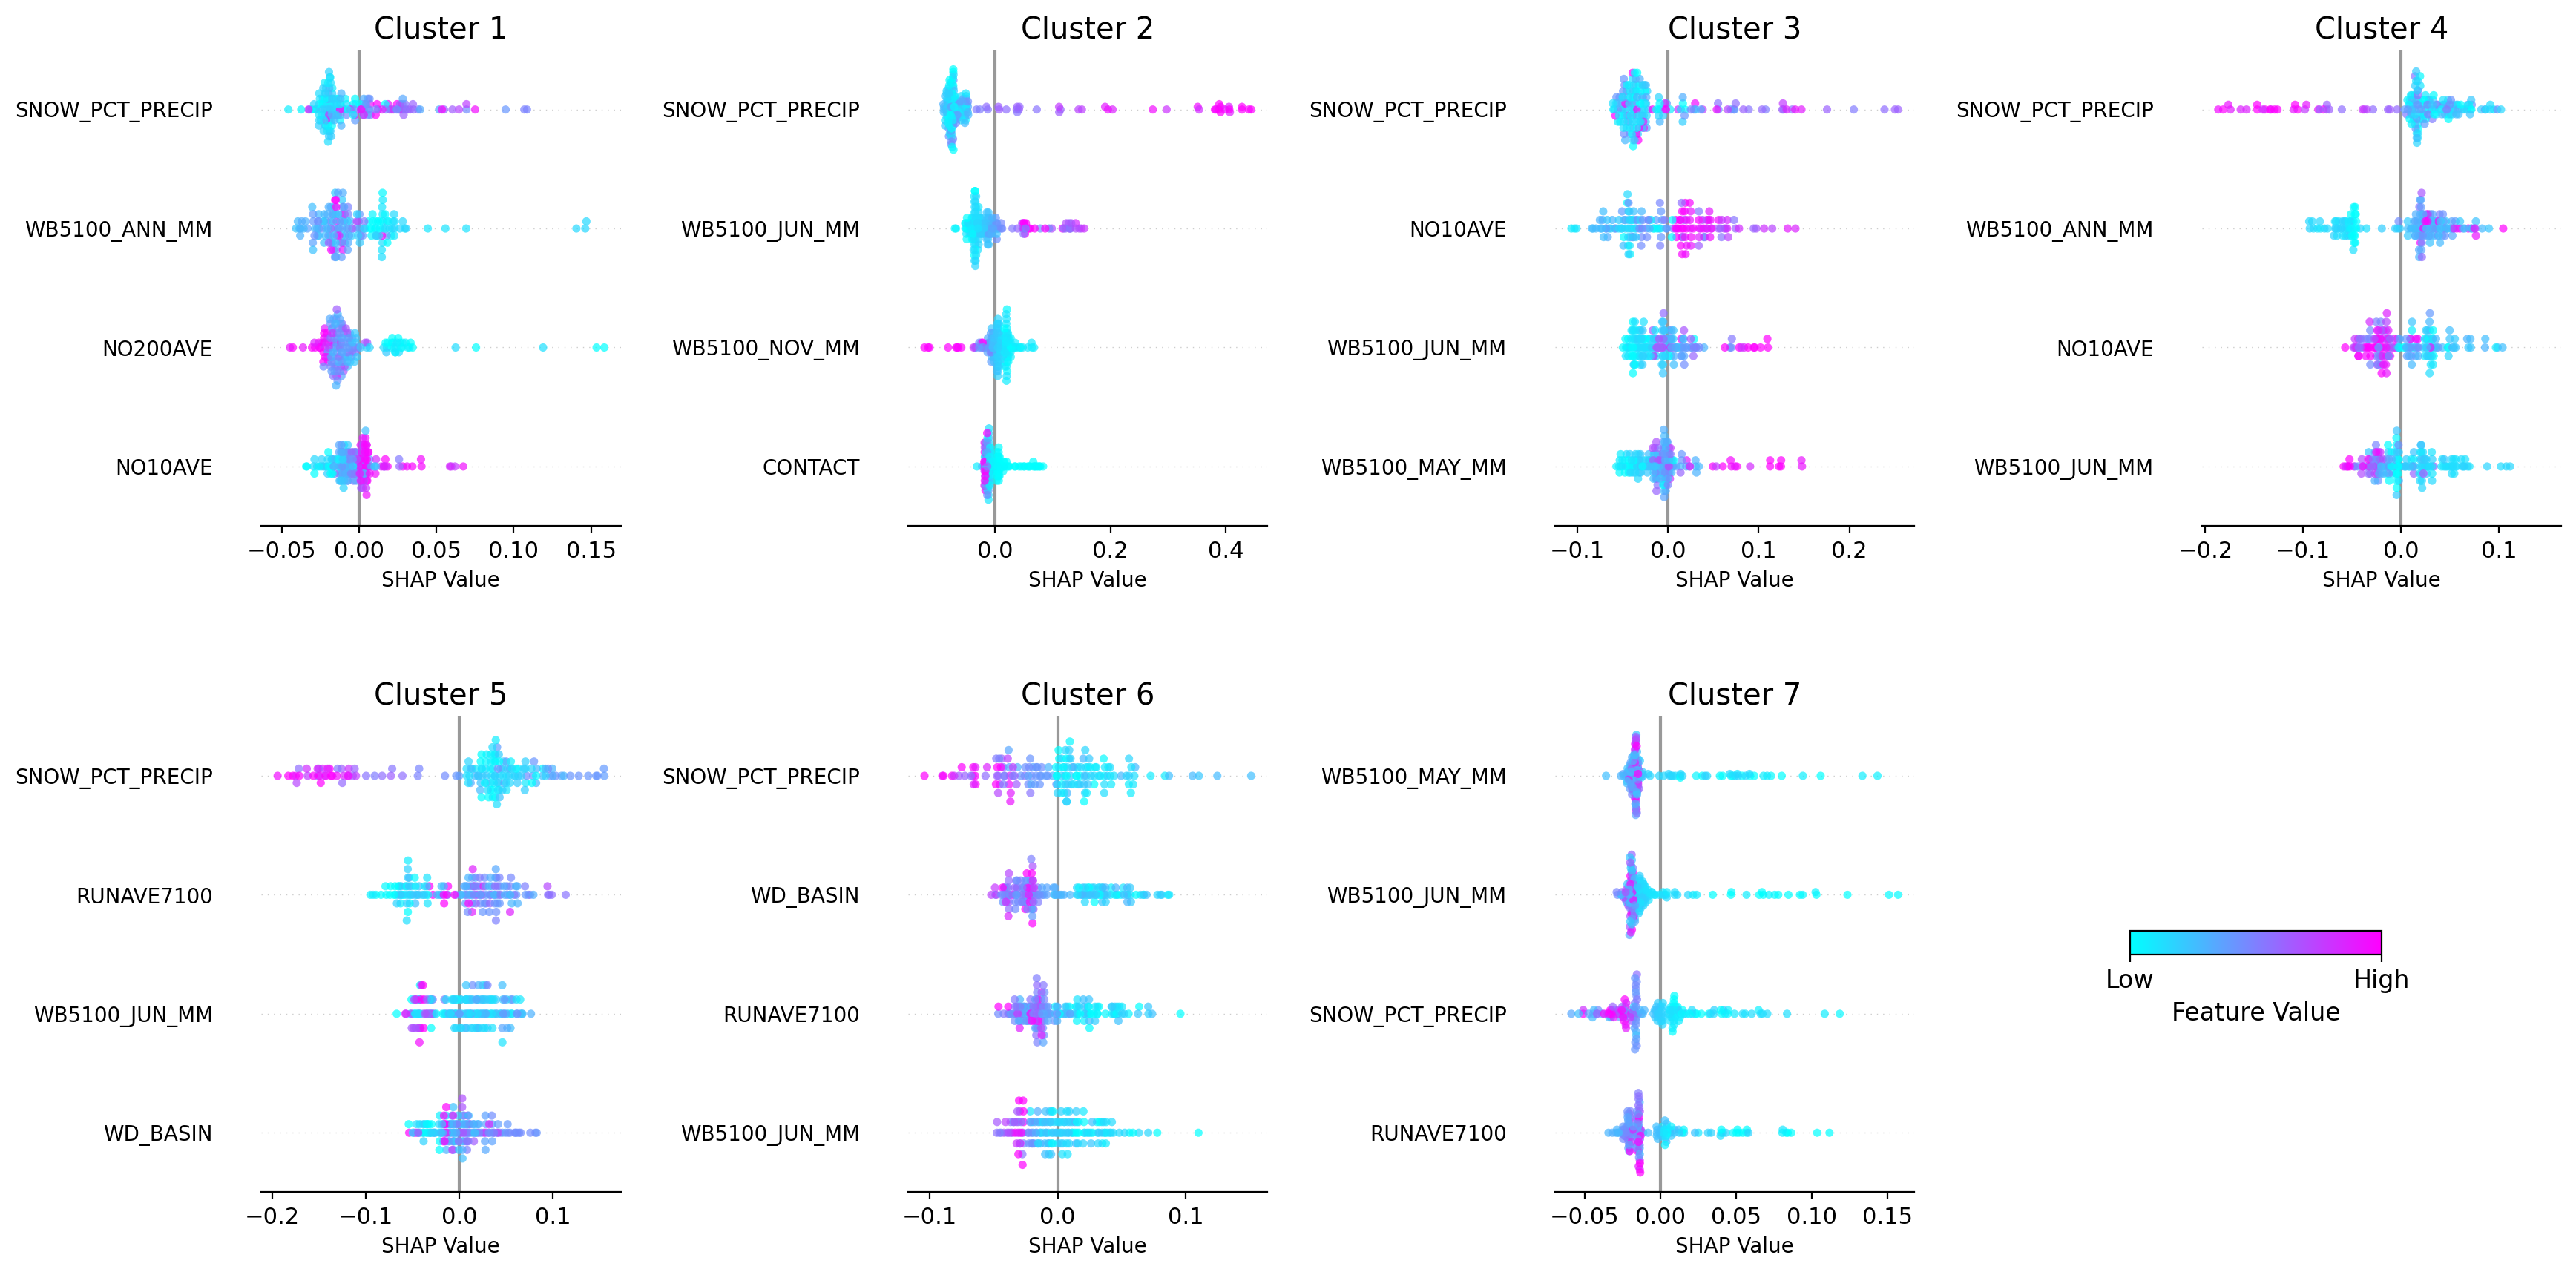

In [30]:
# Assuming shap_values_a and shap_values_b are your SHAP values for two different models or datasets
fig = plt.figure(dpi=200)

for i in range(7):
    ax = fig.add_subplot(2, 4, i+1)
    shap.plots.beeswarm(sv[:,:,i],
                        axis_color  = 'k',
                        color       = plt.get_cmap('cool'),
                        alpha       = 0.7,
                        order       = shap.Explanation.abs.mean(0),
                        color_bar   = False,
                        plot_size   = (20,10),
                        show        = False,
                        )
    
    ax.set_title('Cluster {}'.format(str(i+1)))
    ax.set_ylim(5.5, 9.5)   # only show top 4 features for clarity in this example
    ax.set_xlabel('SHAP Value', fontsize=10)
    ax.tick_params(axis='y', which='major', labelsize=10)

# spacing adjustments to make things look better
plt.subplots_adjust(wspace=0.8, hspace=0.4)

# colorbar
cax = ax.inset_axes([1.6, 0.5, 0.7, 0.05])
img = ax.scatter(x=[0,0], y=[0,0], c=[0,1], cmap='cool')
cbar=fig.colorbar(img, ticks=[0, 1],
                    fraction = 0.05,
                    pad = 0.05,
                    cax=cax,
                    label='Feature Value',
                    orientation='horizontal')
cbar.ax.set_xticklabels(['Low', 'High'])

### 3.4 KDE Plots

Text(0.02, 0.5, 'Density')

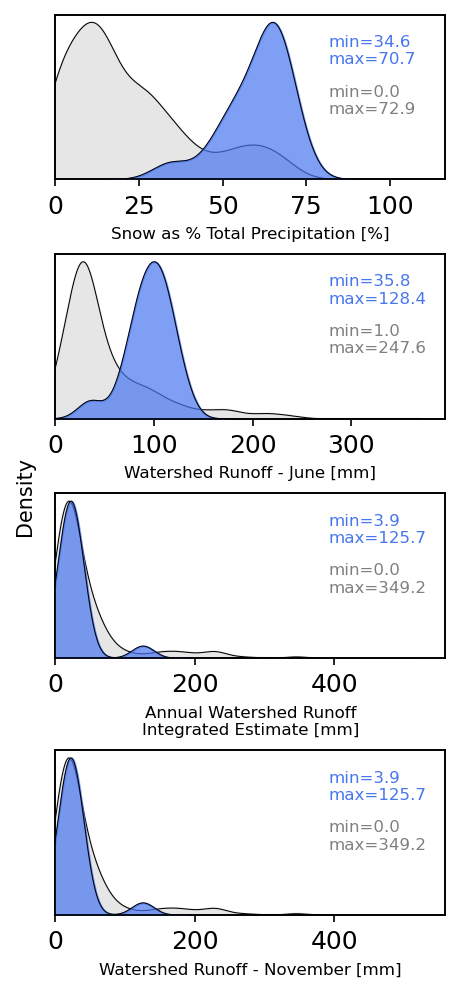

In [34]:
# These characteristics are for Cluster 2, and you will need to change them manually depending on the cluster you want to plot
c = '#4776ee'
var = ['SNOW_PCT_PRECIP', 'WB5100_JUN_MM', 'WB5100_NOV_MM', 'WB5100_NOV_MM']
feat = ['Snow as % Total Precipitation [%]', 'Watershed Runoff - June [mm]', 'Annual Watershed Runoff\nIntegrated Estimate [mm]', 'Watershed Runoff - November [mm]']

anno_coords = [
(0.7, 0.7),
(0.7, 0.7),
(0.7, 0.7),
(0.7, 0.7)
]
dist_coords = [
(0.7, 0.4),
(0.7, 0.4),
(0.7, 0.4),
(0.7, 0.4)
]

# Figure showing distributions
fig, ax = plt.subplots(figsize=(3, 6.5), nrows=4, ncols=1, sharex=False, sharey=False, dpi=150, layout='constrained')

for i in range(0, len(var)):
    kde = data[var[i]]
    plot = kde.plot.kde(ax=ax[i], style=['k'], linewidth=0.5)
    x = plot.get_children()[0]._x
    y = plot.get_children()[0]._y
    
    ax[i].fill_between(x,y,color='gainsboro', alpha=0.7)

    # plot cluster points
    x_clust = X_test[var[i]][X_test['Cluster_H_7'] == clust]
    ax2 = ax[i].twinx()
    var_dist = x_clust.plot.kde(ax=ax2, style=['k'], linewidth=0.5)
    x_var = var_dist.get_children()[0]._x
    y_var = var_dist.get_children()[0]._y
    ax2.fill_between(x_var,y_var,color=c, alpha=0.7, label='_nolegend_')

    ax2.set_ylabel('')
    ax2.set_yticklabels('')
    ax2.set_yticks([])
    ax2.set_ylim(0)

    # Annotation for gray distribution
    ax[i].annotate('min={}\nmax={}'.format(min(kde), max(kde)), dist_coords[i], xycoords='axes fraction', fontsize=8, color='gray')
    # Annotation for color distribution
    ax[i].annotate('min={}\nmax={}'.format(min(x_clust), max(x_clust)), anno_coords[i], xycoords='axes fraction', fontsize=8, color=c)

for i in range(0, len(var)):
    ax[i].set_ylabel('')
    ax[i].set_yticklabels('')
    ax[i].set_yticks([])
    ax[i].set_ylim(0)
    ax[i].set_xlim(0)
    ax[i].set_xlabel(feat[i], fontsize=8)

fig.supylabel('Density', fontsize=10)

## 5. Additional Resources
- **Resources**:
  - [SHAP GitHub repo](https://github.com/slundberg/shap)
  - [Official SHAP documentation and example notebooks](https://shap.readthedocs.io/en/latest/)
  - [Original SHAP paper (Lundberg & Lee, 2017)](https://arxiv.org/pdf/1705.07874)

### Thank you for attending the SHAP Values Workshop. If you have any questions or comments, don't hesitate to reach out.
- Harrison Myers (ghmyers@uvm.edu)
- Ryan van der Heijden (ryan.van-der-heijden@uvm.edu)
- Ali Dadkhah (ali.dadkhah@uvm.edu)
- Shaurya Swami (shaurya.swami@uvm.edu)
- Kristen Underwood (kristen.underwood@uvm.edu)